In this vignette, we aim to illustrate the features of Lasso regression and varbvs. The example data is generated from the 
"leukemia" data used in the original data which consists of genesexpression levels recorded for 3,571 genes in 72 patients with leukemia. Here we use it as genetypes to simulate quantitative phenotypes.
To run this notebook, the genodata 'leukemia.csv' should be put in the folder 'data' .

In [81]:
import numpy as np
import pandas as pd
import varbvs
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from matplotlib import pyplot as plt

Loading the data.  

In [82]:
geno = pd.read_csv('data/leukemia.csv')
print(geno.shape)

(72, 3572)


Setting parameters for simulate the data. *s* is the number of variables with nonzero effects, *pve* is the propotion of variance explained by all variables.

In [83]:
s = 5
pve = 0.4

Setting random seed.

In [144]:
np.random.seed(1)

In [85]:
x = geno.iloc[:, 1:].values
n, p = x.shape
print('shape of variable matrix:', x.shape)

shape of variable matrix: (72, 3571)


Simulate quantitive phenotype based on linear model, the index of effective variables are randomly sampled.

In [145]:
beta = np.zeros(p)
index = np.random.choice(list(range(p)), s, replace=False)
beta[index] = np.random.randn(s)
xr = x.dot(beta)
sigma2 = np.var(xr) * (1 - pve) / pve
epsilon = np.random.randn(n) * np.sqrt(sigma2)
y = xr + epsilon

Fit Lasso by the typical *sklearn* package.

In [87]:
alphas = np.logspace(-2, 1, 100)
cv = 20

In [99]:
fit_lasso_cv = linear_model.LassoCV(alphas=alphas, cv=cv).fit(x, y)
mse_lasso_cv = fit_lasso_cv.mse_path_
alpha_ = fit_lasso_cv.alpha_
index = fit_lasso_cv.coef_ != 0

In [89]:
print('alpha:', alpha_)

alpha: 0.6135907273413173


In [90]:
mse_lasso = np.zeros(len(alphas))
nzero_lasso = np.zeros(len(alphas))
coef_lasso = np.zeros((len(alphas), p))
for i in range(len(alphas)):
    fit_lasso = linear_model.Lasso(alpha=alphas[i],max_iter=10000).fit(x, y)
    mse_lasso[i] = mean_squared_error(y, fit_lasso.predict(x))
    nzero_lasso[i] = np.sum(fit_lasso.coef_ != 0)
    coef_lasso[i, :] = fit_lasso.coef_


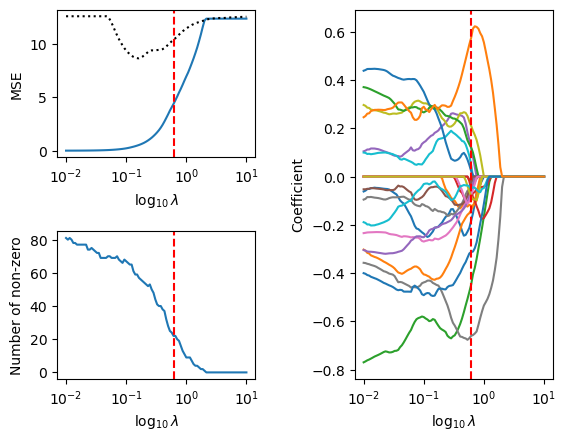

In [108]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['xtick.minor.size'] = 0
ax1 = plt.subplot(221)
ax1.plot(alphas, mse_lasso)
ax1.plot(alphas, fit_lasso_cv.mse_path_.mean(axis=1), color='black', linestyle=':')
ax1.set_xscale('log')
ax1.set_ylabel('MSE')
ax1.set_xlabel(r'$\log_{10}\lambda$')
ax1.axvline(alpha_, color='red', linestyle='--')

ax2 = plt.subplot(223)
ax2.plot(alphas, nzero_lasso)
ax2.set_xscale('log')
ax2.set_ylabel('Number of non-zero')
ax2.set_xlabel(r'$\log_{10}\lambda$')
ax2.axvline(alpha_, color='red', linestyle='--')

ax3 = plt.subplot(122)
ax3.plot(alphas, coef_lasso[: , index])
ax3.set_xscale('log')
ax3.set_xlabel(r'$\log_{10}\lambda$')
ax3.set_ylabel('Coefficient')
ax3.axvline(alpha_, color='red', linestyle='--')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

Fit varbvs with our implementation.

In [96]:
logodds = np.linspace(-np.log10(p),-1,40)
log10prior = - np.log10((1 + 10**(-logodds)))
fit_varbvs = varbvs.varbvs(x, y)
pip_varbvs = fit_varbvs.fit(logodds=logodds)
m = log10prior.shape[0]

In [114]:
logw = np.zeros(m)
mse_varbvs = np.zeros(m)
nzero_varbvs = np.zeros(m)
coef_varbvs = np.zeros((m, p)) 
for j in range(m):
    subfit = varbvs.varbvs(x, y)
    pip = subfit.fit(logodds=logodds[j])
    mse_varbvs[j] = mean_squared_error(y, subfit.predict(x))
    nzero_varbvs[j] = np.sum(pip)
    coef_varbvs[j, :] = subfit.betahat
    logw[j] = subfit.logw[0]

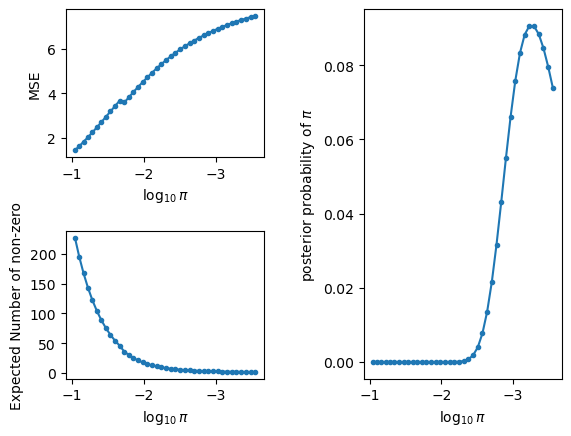

In [113]:
ax1 = plt.subplot(221)
ax1.plot(log10prior, mse_varbvs, '.-')
ax1.set_ylabel('MSE')
ax1.set_xlabel(r'$\log_{10}\pi$')
ax1.invert_xaxis()

ax2 = plt.subplot(223)
ax2.plot(log10prior, nzero_varbvs, '.-')
ax2.set_ylabel('Expected Number of non-zero')
ax2.set_xlabel(r'$\log_{10}\pi$')
ax2.invert_xaxis()

ax3 = plt.subplot(122)
ax3.plot(log10prior, np.exp(logw - np.max(logw))/np.sum(np.exp(logw - np.max(logw))), '.-')
ax3.set_xlabel(r'$\log_{10}\pi$')
ax3.set_ylabel(r'posterior probability of $\pi$')
ax3.invert_xaxis()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

Text(0, 0.5, 'posterior probability of inclusion')

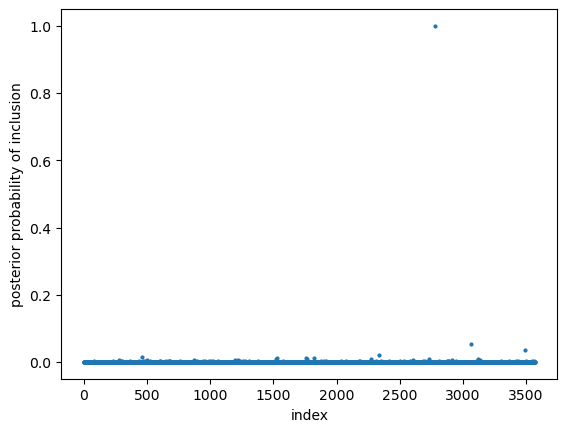

In [148]:
plt.scatter(range(p), pip_varbvs, s=4)
plt.xlabel('index')
plt.ylabel('posterior probability of inclusion')